<a href="https://colab.research.google.com/github/ryanraba/junk/blob/main/autoencoder_tracker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Datasets

I exported four batches of 1-hour ADS-B data along the east coast of the US from Optix to CSV and uploaded here.  Can also do arrow format.

Apparently only a handful of columns have meaningful information populated, so I pulled that out and made a concatenanted master list of training data.

In [ ]:
# IF PARSING ARROW FROM STEALTH

#import pyarrow as pa
#import pyarrow.ipc
#import pandas as pd

#with open('ads_b.arrow', 'rb') as f:
#    data = pa.ipc.RecordBatchStreamReader(f).read_all().to_pydict()

#pdf = pd.DataFrame(data['aireon_historic'])
#pdf[['lat','lon']] = pdf['geom'].to_list()
#pdf = pdf.drop(columns=['geom'])
#pdf

In [1]:
import pandas as pd

# DO ONCE FOR NEW TRAINING DATA

#pdf = None
#for ff in ['Commercial_ADS_B_Query__1', 'Commercial_ADS_B_Query__2', 'Commercial_ADS_B_Query__3', 'Commercial_ADS_B_Query__4']:
#    tdf = pd.read_csv('drive/MyDrive/Colab Notebooks/Data/%s.csv' % ff)
#    tdf = tdf[['dtg','ModeSAddress','HighResPositionLat','HighResPositionLon','FlightLevel']]
#    pdf = tdf if pdf is None else pd.concat([pdf, tdf], ignore_index=True).reset_index(drop=True)

#pdf = pdf.fillna(0.0)
#pdf['dtg'] = pd.to_datetime(pdf['dtg'], format='mixed')
#pdf = pdf.sort_values(['dtg']).reset_index(drop=True)
#pdf['epoch'] = (pdf['dtg'] - pdf['dtg'].iloc[0]).dt.total_seconds()
#pdf.to_csv('drive/MyDrive/Colab Notebooks/Data/Commercial_ADS_B_Combined_Reduced.csv', index=False)

pdf = pd.read_csv('drive/MyDrive/Colab Notebooks/Data/Commercial_ADS_B_Combined_Reduced.csv').sort_values(['epoch']).reset_index(drop=True)
pdf

,dtg,ModeSAddress,HighResPositionLat,HighResPositionLon,FlightLevel,epoch
0,2025-05-16 15:11:07.016,ABD50F,42.6594,-70.7468,131.50,0.000
1,2025-05-16 15:11:07.023,A6833B,42.1209,-71.0172,51.50,0.007
2,2025-05-16 15:11:07.031,A69C3F,35.5313,-78.7325,370.00,0.015
3,2025-05-16 15:11:07.063,AC7581,39.8735,-75.2448,0.00,0.047
4,2025-05-16 15:11:07.063,A4DAD4,42.0076,-74.1319,156.00,0.047
...,...,...,...,...,...,...
1606542,2025-05-16 19:11:07.953,A1B092,43.3501,-75.1041,300.00,14400.937
1606543,2025-05-16 19:11:07.953,A9618A,35.2186,-80.9466,0.00,14400.937
1606544,2025-05-16 19:11:07.977,AC90A7,35.2245,-80.9509,0.00,14400.961
1606545,2025-05-16 19:11:07.977,A2F5B4,42.3873,-75.7811,299.25,14400.961


# Vectorization and Normalization

Prepare data for training a model.

In [21]:
import numpy as np

MAXLEN = 64
FEATS = ['HighResPositionLat','HighResPositionLon','FlightLevel','epoch']

cdf = pdf.groupby(['ModeSAddress'])
dmap = []

# vectorization
X = np.array([cdf.get_group((gg,))[FEATS].values[-MAXLEN:] for ii, gg in enumerate(cdf.groups) if cdf.get_group((gg,)).shape[0] >= MAXLEN])
dmap = [gg for ii, gg in enumerate(cdf.groups) if cdf.get_group((gg,)).shape[0] >= MAXLEN]

# mean normalization within each sample
for kk in range(0,len(X)):
    divisor = np.ptp(X[kk], axis=0)
    divisor[divisor==0] = 1
    X[kk] = (X[kk] - np.mean(X[kk], axis=0))/divisor

print(len(cdf.groups), X.shape)

6098 (3970, 64, 4)


# Build and Train an Autoencoder

Convolutional Neural Networks work well on a lot of different things.  Autoencoder means output is set to input and no truth data is required.

Model will be split into encoder and decoder halves after training. Just the encoder half is needed later.

In [61]:
# here we build and train a CNN model
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D
from keras.layers import Flatten, Reshape, Permute, RepeatVector
from keras.models import Model, load_model
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from IPython.display import clear_output

ins = Input(shape=(X.shape[1], X.shape[2],))

encoded = Conv1D(4, 1, activation='tanh', padding='same')(ins)           # (None, MAXLEN, 4)
encoded = MaxPooling1D(pool_size=2, strides=2, padding='same')(encoded)  # (None, MAXLEN/2, 4)
encoded = Conv1D(4, 1, activation='tanh', padding='same')(encoded)       # (None, MAXLEN/2, 4)
encoded = MaxPooling1D(pool_size=2, strides=2, padding='same')(encoded)  # (None, MAXLEN/4, 4)
encoded = Conv1D(4, 1, activation='tanh', padding='same')(encoded)       # (None, MAXLEN/4, 4)
encoded = MaxPooling1D(pool_size=2, strides=2, padding='same')(encoded)  # (None, MAXLEN/8, 4)
encoded = Conv1D(4, 1, activation='tanh', padding='same')(encoded)       # (None, MAXLEN/8, 4)

decoded = UpSampling1D(8)(encoded)                                       # (None, MAXLEN/2, 2)
decoded = Conv1D(4, 1, activation='tanh', padding='same')(decoded)       # (None, MAXLEN/2, 4)

autoencoder = Model(ins, decoded)
encoder = Model(ins, encoded)

autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(x=X,
                y=X,
                batch_size=128,
                epochs=500,
                verbose=0,
                validation_split=0.2,
                shuffle=True)


# Reduce Dimensionality of Embedded Space

The encoder half of the autoencoder can now be used to transform the input ADS-B tracks to an embedded latent space within the neural network. This represents how the NN generalized the different patterns it saw in the training data.

We want to reduce the high dimensionality of the embedded space down to 2-D so we can see what's what.  The T-SNE algorithm from Scikit-Learn works well for this.

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


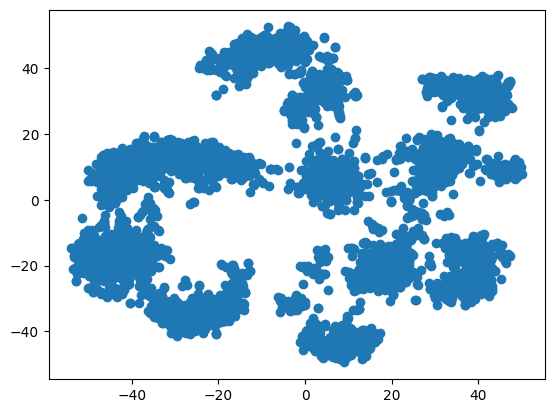

In [62]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

embedded_data = encoder.predict(X).reshape(X.shape[0],-1)

embedded_model = TSNE(n_components=2,
                      early_exaggeration=20.0,
                      learning_rate=1000,
                      init='pca',
                      perplexity=50)

reduced_embeddings = embedded_model.fit_transform(embedded_data)

plt.scatter(reduced_embeddings[:,0], reduced_embeddings[:,1])

# Inspect different embedded groupings

We can see from the plot of the encoders embedded latent space that it is clearly separating the input ADS-B tracks into different groupings. We have no idea why though, so lets sample some of the different groups and inspect what is going on.

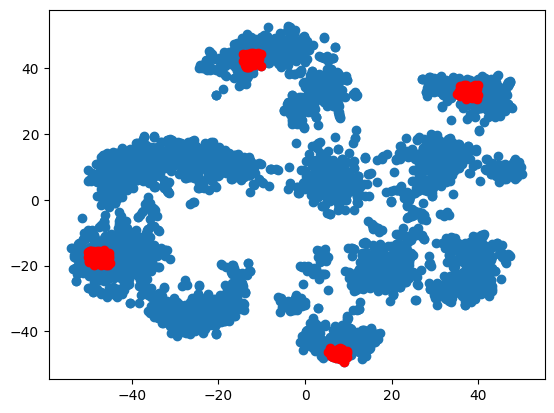

In [67]:
samples1 = np.where((reduced_embeddings[:,0] > -50) & (reduced_embeddings[:,0] < -45) & (reduced_embeddings[:,1] > -20) & (reduced_embeddings[:,1] < -15))[0]
samples2 = np.where((reduced_embeddings[:,0] > -15) & (reduced_embeddings[:,0] < -10) & (reduced_embeddings[:,1] > 40) & (reduced_embeddings[:,1] < 45))[0]
samples3 = np.where((reduced_embeddings[:,0] > 35) & (reduced_embeddings[:,0] < 40) & (reduced_embeddings[:,1] > 30) & (reduced_embeddings[:,1] < 35))[0]
samples4 = np.where((reduced_embeddings[:,0] > 5) & (reduced_embeddings[:,0] < 10) & (reduced_embeddings[:,1] > -50) & (reduced_embeddings[:,1] < -45))[0]

plt.scatter(reduced_embeddings[:,0], reduced_embeddings[:,1])
plt.scatter(reduced_embeddings[samples1,0], reduced_embeddings[samples1,1], c='r')
plt.scatter(reduced_embeddings[samples2,0], reduced_embeddings[samples2,1], c='r')
plt.scatter(reduced_embeddings[samples3,0], reduced_embeddings[samples3,1], c='r')
plt.scatter(reduced_embeddings[samples4,0], reduced_embeddings[samples4,1], c='r')

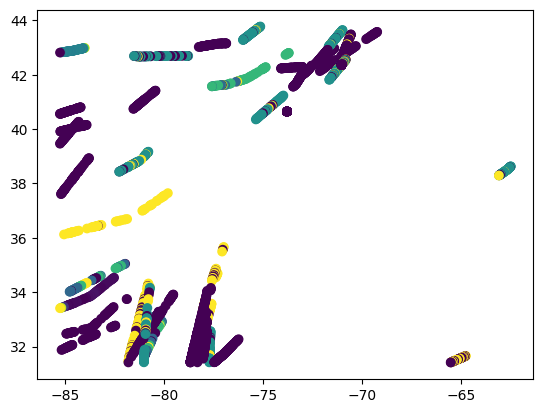

In [68]:
for ss in samples1:
  gg = cdf.get_group((dmap[ss],))
  plt.scatter(gg['HighResPositionLon'][-MAXLEN:], gg['HighResPositionLat'][-MAXLEN:], c=gg['FlightLevel'][-MAXLEN:])

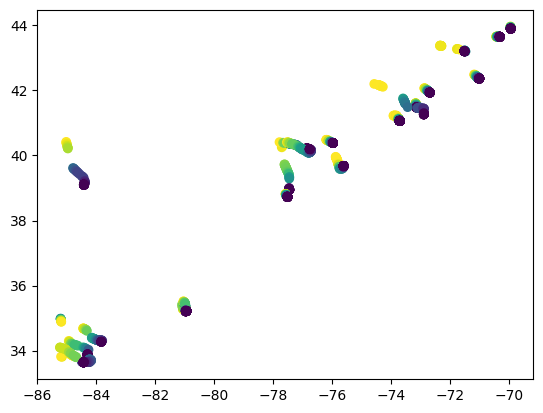

In [69]:
for ss in samples2:
  gg = cdf.get_group((dmap[ss],))
  plt.scatter(gg['HighResPositionLon'][-MAXLEN:], gg['HighResPositionLat'][-MAXLEN:], c=gg['FlightLevel'][-MAXLEN:])

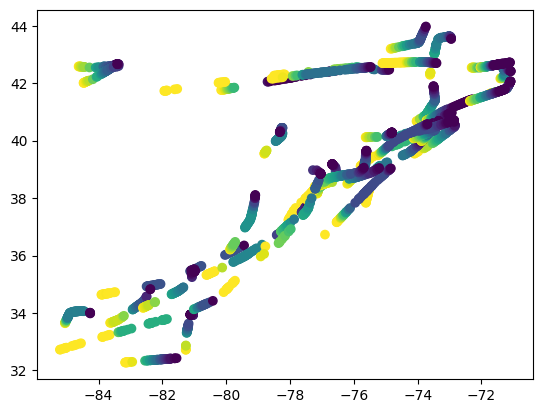

In [70]:
for ss in samples3:
  gg = cdf.get_group((dmap[ss],))
  plt.scatter(gg['HighResPositionLon'][-MAXLEN:], gg['HighResPositionLat'][-MAXLEN:], c=gg['FlightLevel'][-MAXLEN:])

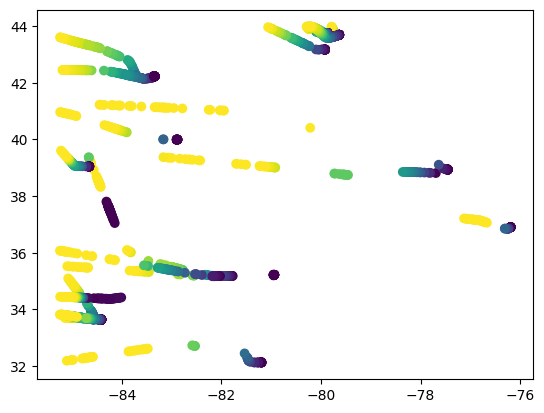

In [71]:
for ss in samples4:
  gg = cdf.get_group((dmap[ss],))
  plt.scatter(gg['HighResPositionLon'][-MAXLEN:], gg['HighResPositionLat'][-MAXLEN:], c=gg['FlightLevel'][-MAXLEN:])

There are defintely different things happening in each group.

To further refine this method, we would of course want a lot more data, probably a (slightly) larget NN model with some regularization added, and we'd want to add more features to start and see what affect the features have on the resulting groupings.  This is our primary way of influencing what the model clusters on.

Ultimately the goal would be to produce a model with at least one cluster in the embedded space that corresponds to an activity we are interested in.  Then, the trained model could be run in real-time on new live data that comes in, and an alert issues whenever that cluster lights up when presented with a live track.